In [34]:
import pandas as pd
import numpy as np


library_df = pd.read_csv("../Datasets/Merged_Data/merged_data.csv")

final_features = [
    "UNEMPLOYMENT_RATE", "MEDIAN_INCOME", "BACHELORS_PERCENT", "TOTCIR", "F_TOTCIR", 
    "VISITS", "F_VISITS", "REGBOR", "F_REGBOR", "GPTERMS", "F_GPTERM", "TOTSTAFF", 
    "F_TOTSTF", "HRS_OPEN", "F_HRS_OP", "TOTPRO", "F_TOTPRO", "TOTATTEN", "F_TOTATT", 
    "TOTINCM", "F_TOTINC", "TOTOPEXP", "F_TOTOPX", "POPU_UND"
    ]

# Create a copy of the dataframe
analysis_df = library_df.loc[:, final_features].copy()

print(analysis_df.columns.tolist())

['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'TOTCIR', 'F_TOTCIR', 'VISITS', 'F_VISITS', 'REGBOR', 'F_REGBOR', 'GPTERMS', 'F_GPTERM', 'TOTSTAFF', 'F_TOTSTF', 'HRS_OPEN', 'F_HRS_OP', 'TOTPRO', 'F_TOTPRO', 'TOTATTEN', 'F_TOTATT', 'TOTINCM', 'F_TOTINC', 'TOTOPEXP', 'F_TOTOPX', 'POPU_UND']


# Data Preprocessing

In [35]:
# Step 1a: Replace the sentinel for missing income
analysis_df["MEDIAN_INCOME"] = analysis_df["MEDIAN_INCOME"].replace(-666666666.0, np.nan)

# Step 1b: Treat zeros in the other three features as missing
for col in ["BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]:
    analysis_df[col] = analysis_df[col].replace(0.0, np.nan)


In [36]:
feature_to_flag = {
    "TOTCIR": "F_TOTCIR",
    "VISITS": "F_VISITS",
    "HRS_OPEN": "F_HRS_OP",
    "GPTERMS": "F_GPTERM",
    "TOTATTEN": "F_TOTATT",
    "REGBOR": "F_REGBOR",
    "TOTPRO": "F_TOTPRO",
    "TOTSTAFF": "F_TOTSTF",
    "TOTINCM": "F_TOTINC",
    "TOTOPEXP": "F_TOTOPX"
}

drop_flags = ['U_22', 'H_22', 'L_22']

In [37]:
# Step 2: Convert 0, -1, -3 and -9 into NaN for each feature
for feat in feature_to_flag:
    if feat in analysis_df:
        analysis_df[feat] = analysis_df[feat].replace([0, -1, -3], np.nan)

analysis_df["POPU_UND"] = analysis_df["POPU_UND"].replace([-1, -3, -9], np.nan)


In [38]:
# Step 3: Drop rows with NaN POPU_UND values
analysis_df.dropna(subset=["POPU_UND"], inplace=True)

In [39]:
# Step 3: Null‑out values whose flag indicates suppression/unusable data
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        mask = analysis_df[flag].isin(drop_flags)
        analysis_df.loc[mask, feat] = np.nan

In [40]:
# Step 4: Create binary “_IMPUTED” indicator columns
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        analysis_df[f"{feat}_IMPUTED"] = analysis_df[flag].str.startswith("I")

In [41]:
# Step 5: Drop the original F_* flag columns
analysis_df.drop(columns=list(feature_to_flag.values()), inplace=True)

In [42]:

# Step 6a: List all columns impute:
cols_to_impute = list(feature_to_flag.keys()) + ["MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]

# Step 6b: Impute the columns using the median since some of the features are heavily skewed:
for col in cols_to_impute:
    median_val = analysis_df[col].median()
    analysis_df[col] = analysis_df[col].fillna(median_val)
   
    
# Confirm there are no NaN values left in the dataset
print(analysis_df.isna().sum())

UNEMPLOYMENT_RATE    0
MEDIAN_INCOME        0
BACHELORS_PERCENT    0
TOTCIR               0
VISITS               0
REGBOR               0
GPTERMS              0
TOTSTAFF             0
HRS_OPEN             0
TOTPRO               0
TOTATTEN             0
TOTINCM              0
TOTOPEXP             0
POPU_UND             0
TOTCIR_IMPUTED       0
VISITS_IMPUTED       0
HRS_OPEN_IMPUTED     0
GPTERMS_IMPUTED      0
TOTATTEN_IMPUTED     0
REGBOR_IMPUTED       0
TOTPRO_IMPUTED       0
TOTSTAFF_IMPUTED     0
TOTINCM_IMPUTED      0
TOTOPEXP_IMPUTED     0
dtype: int64


# Feature Engineering

In [43]:
# Per-Capita Metrics
analysis_df["CHECKOUTS_PER_CAPITA"] = analysis_df["TOTCIR"] / analysis_df["POPU_UND"]
analysis_df["ATTENDANCE_PER_CAPITA"] = analysis_df["TOTATTEN"] / analysis_df["POPU_UND"]
analysis_df["VISITS_PER_CAPITA"] = analysis_df["VISITS"] / analysis_df["POPU_UND"]


derived_feature_map = {
    "CHECKOUTS_PER_CAPITA": "TOTCIR",
    "VISITS_PER_CAPITA": "VISITS",
    "ATTENDANCE_PER_CAPITA": "TOTATTEN",
}


# Rename the *_IMPUTED columns according to the derived features
for new_col, original_col in derived_feature_map.items():
    imputed_col = f"{original_col}_IMPUTED"
    if imputed_col in analysis_df.columns:
        analysis_df.rename(columns={imputed_col: f"{new_col}_IMPUTED"}, inplace=True)

# Drop redundant features
analysis_df.drop(columns=["TOTCIR", "VISITS", "TOTATTEN"], inplace=True)

print(analysis_df.columns.tolist())
    

['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'REGBOR', 'GPTERMS', 'TOTSTAFF', 'HRS_OPEN', 'TOTPRO', 'TOTINCM', 'TOTOPEXP', 'POPU_UND', 'CHECKOUTS_PER_CAPITA_IMPUTED', 'VISITS_PER_CAPITA_IMPUTED', 'HRS_OPEN_IMPUTED', 'GPTERMS_IMPUTED', 'ATTENDANCE_PER_CAPITA_IMPUTED', 'REGBOR_IMPUTED', 'TOTPRO_IMPUTED', 'TOTSTAFF_IMPUTED', 'TOTINCM_IMPUTED', 'TOTOPEXP_IMPUTED', 'CHECKOUTS_PER_CAPITA', 'ATTENDANCE_PER_CAPITA', 'VISITS_PER_CAPITA']


# Exploratory Data Analysis (EDA)

In [44]:
# Data shape and types
print("Shape:", analysis_df.shape)
print("\nDtypes:\n", analysis_df.dtypes)

Shape: (9160, 24)

Dtypes:
 UNEMPLOYMENT_RATE                float64
MEDIAN_INCOME                    float64
BACHELORS_PERCENT                float64
REGBOR                           float64
GPTERMS                          float64
TOTSTAFF                         float64
HRS_OPEN                         float64
TOTPRO                           float64
TOTINCM                          float64
TOTOPEXP                         float64
POPU_UND                         float64
CHECKOUTS_PER_CAPITA_IMPUTED        bool
VISITS_PER_CAPITA_IMPUTED           bool
HRS_OPEN_IMPUTED                    bool
GPTERMS_IMPUTED                     bool
ATTENDANCE_PER_CAPITA_IMPUTED       bool
REGBOR_IMPUTED                      bool
TOTPRO_IMPUTED                      bool
TOTSTAFF_IMPUTED                    bool
TOTINCM_IMPUTED                     bool
TOTOPEXP_IMPUTED                    bool
CHECKOUTS_PER_CAPITA             float64
ATTENDANCE_PER_CAPITA            float64
VISITS_PER_CAPITA            

In [45]:
# Head and descriptive stats
display(analysis_df.head())
display(analysis_df.describe().T)

,UNEMPLOYMENT_RATE,MEDIAN_INCOME,BACHELORS_PERCENT,REGBOR,GPTERMS,TOTSTAFF,HRS_OPEN,TOTPRO,TOTINCM,TOTOPEXP,...,GPTERMS_IMPUTED,ATTENDANCE_PER_CAPITA_IMPUTED,REGBOR_IMPUTED,TOTPRO_IMPUTED,TOTSTAFF_IMPUTED,TOTINCM_IMPUTED,TOTOPEXP_IMPUTED,CHECKOUTS_PER_CAPITA,ATTENDANCE_PER_CAPITA,VISITS_PER_CAPITA
0,108.0,58018.0,279.0,1950.0,5.0,0.68,1404.0,150.0,71874.0,66006.0,...,False,False,False,False,False,False,False,4.143130,0.428435,2.446088
1,416.0,72958.0,1832.0,123846.0,161.0,60.00,7596.0,758.0,9357471.0,9181224.0,...,False,False,False,False,False,False,False,3.037981,0.037071,0.902910
2,3.0,111250.0,6.0,138.0,9.0,0.30,420.0,164.0,13885.0,15337.0,...,False,False,True,False,True,False,True,4.352273,13.562500,2.392045
3,363.0,94313.0,376.0,2062.0,8.0,2.50,2040.0,80.0,138115.0,241204.0,...,False,False,False,False,False,False,False,1.584882,0.742576,2.035414
4,566.0,87247.0,1629.0,2867.0,7.0,6.00,2356.0,249.0,417502.0,394686.0,...,False,False,False,False,False,False,False,2.863800,0.870285,2.700359


,count,mean,std,min,25%,50%,75%,max
UNEMPLOYMENT_RATE,9160.0,3.287876e+02,4.458864e+02,1.000000,46.000000,150.000000,4.392500e+02,3.987000e+03
MEDIAN_INCOME,9160.0,7.462841e+04,3.033740e+04,10850.000000,55810.250000,67402.000000,8.524000e+04,2.500010e+05
BACHELORS_PERCENT,9160.0,1.751628e+03,2.410978e+03,1.000000,231.000000,720.000000,2.288000e+03,2.154900e+04
REGBOR,9160.0,1.706863e+04,7.811875e+04,1.000000,998.750000,3068.000000,9.857000e+03,2.863691e+06
GPTERMS,9160.0,2.997653e+01,1.128313e+02,1.000000,5.000000,9.000000,2.000000e+01,3.790000e+03
TOTSTAFF,9160.0,1.539622e+01,5.528598e+01,0.030000,1.510000,4.000000,1.100000e+01,2.197960e+03
HRS_OPEN,9160.0,3.759295e+03,7.951827e+03,12.000000,1680.000000,2286.000000,2.950000e+03,2.122850e+05
TOTPRO,9160.0,3.736803e+02,1.105573e+03,1.000000,66.000000,164.000000,3.572500e+02,6.359800e+04
TOTINCM,9160.0,1.704200e+06,7.905360e+06,236.000000,89986.750000,288921.000000,1.010849e+06,3.517798e+08
TOTOPEXP,9160.0,1.535148e+06,7.212341e+06,378.000000,85330.000000,266639.000000,9.111360e+05,3.319634e+08


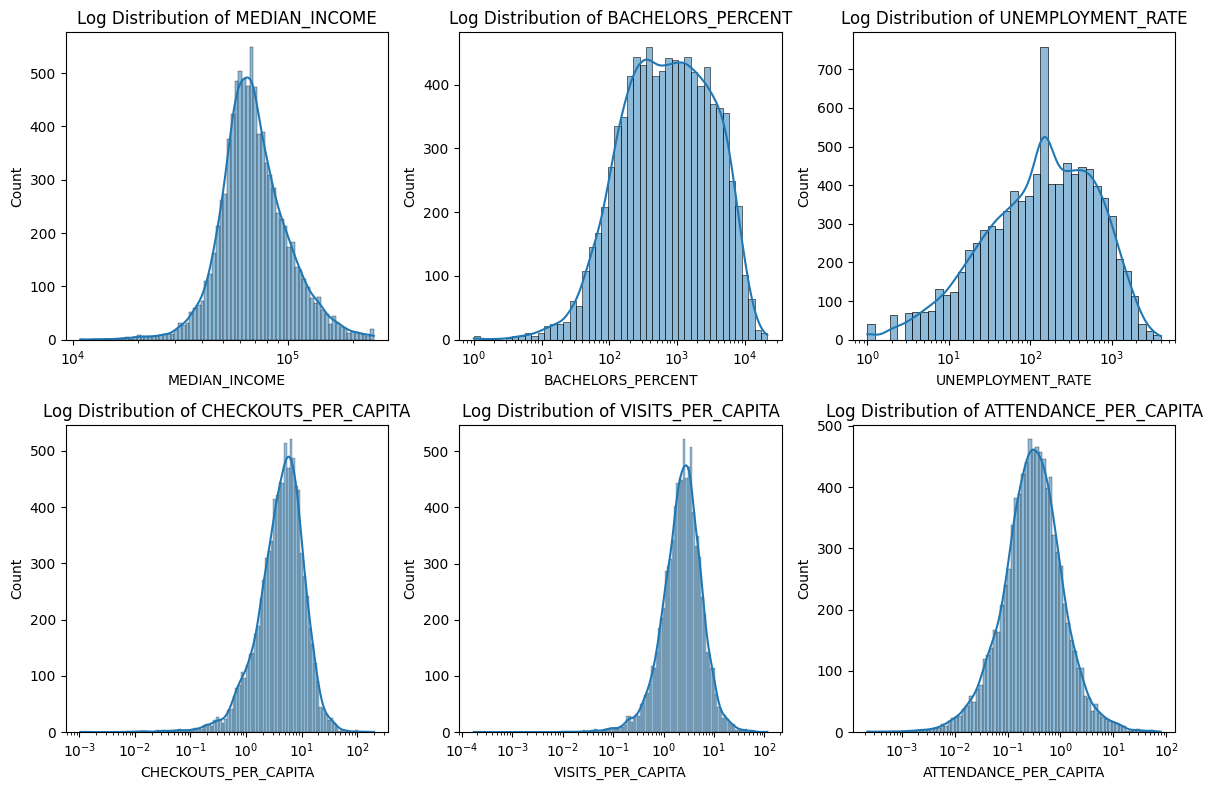

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", 
    "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(analysis_df[feature], kde=True, log_scale=True)
    plt.title(f"Log Distribution of {feature}")
plt.tight_layout()
plt.show()

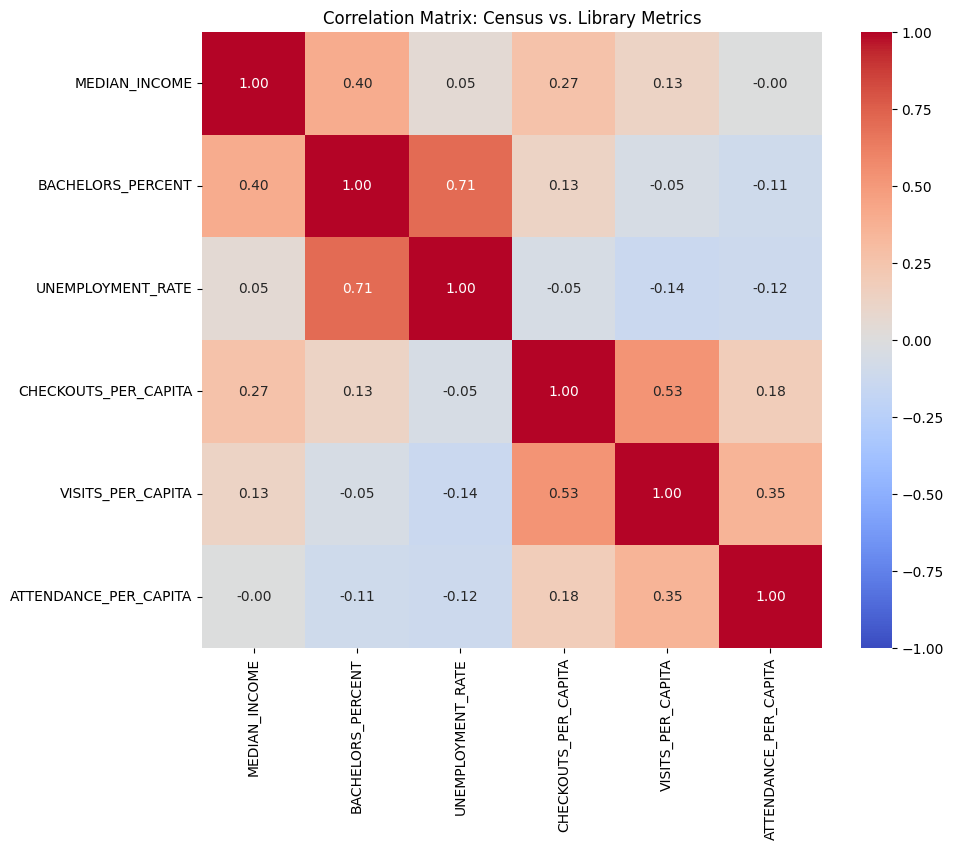

In [47]:
# Correlation matrix (focus on census vs. library metrics)
correlation_features = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    analysis_df[correlation_features].corr(),
    annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f"
)
plt.title("Correlation Matrix: Census vs. Library Metrics")
plt.show()

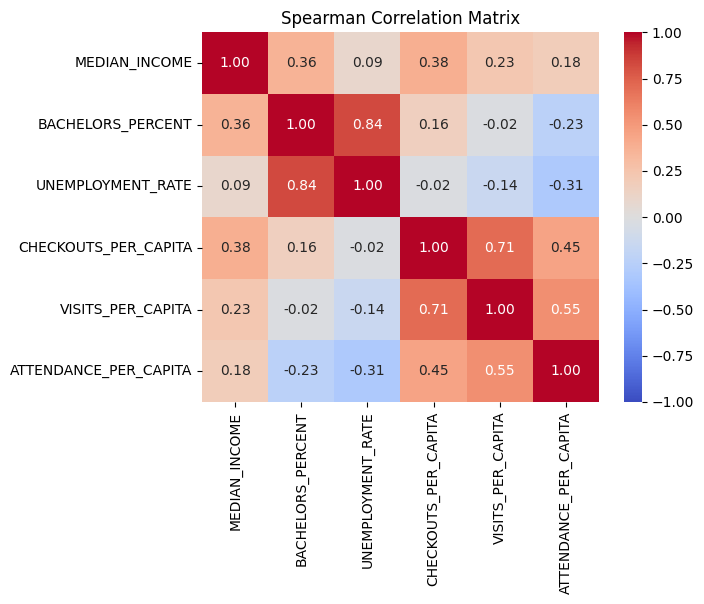

In [48]:
# Compute Spearman correlation
spearman_corr = analysis_df[correlation_features].corr(method="spearman")

# Visualize
sns.heatmap(
    spearman_corr, 
    annot=True, cmap="coolwarm", vmin=-1, vmax=1,
    annot_kws={"size": 10}, fmt=".2f"
)
plt.title("Spearman Correlation Matrix")
plt.show()

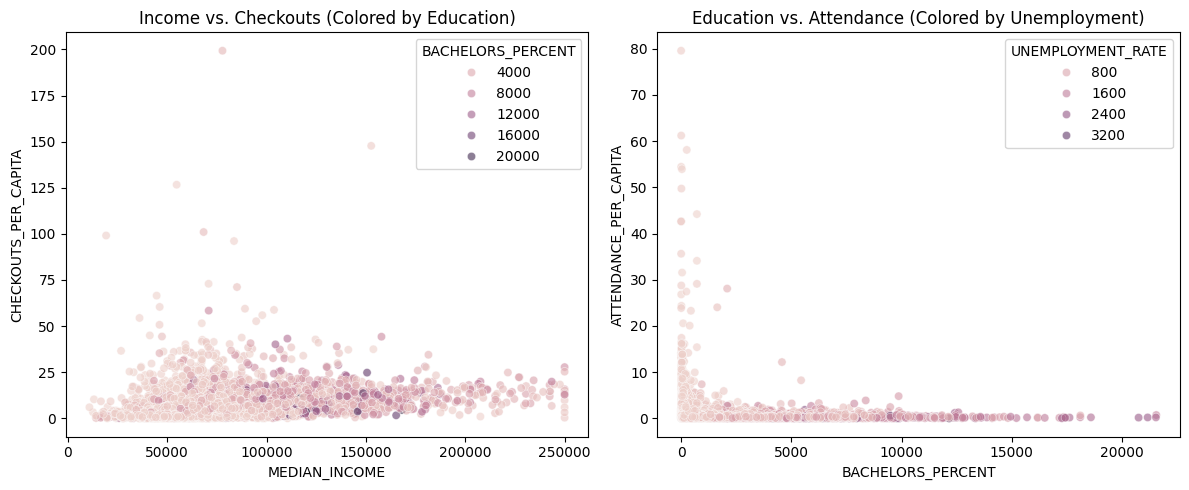

In [49]:
# Scatter plots: Income/Education vs. Checkouts/Attendance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="MEDIAN_INCOME", y="CHECKOUTS_PER_CAPITA",
    hue="BACHELORS_PERCENT", data=analysis_df, alpha=0.6
)
plt.title("Income vs. Checkouts (Colored by Education)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="BACHELORS_PERCENT", y="ATTENDANCE_PER_CAPITA",
    hue="UNEMPLOYMENT_RATE", data=analysis_df, alpha=0.6
)
plt.title("Education vs. Attendance (Colored by Unemployment)")
plt.tight_layout()
plt.show()

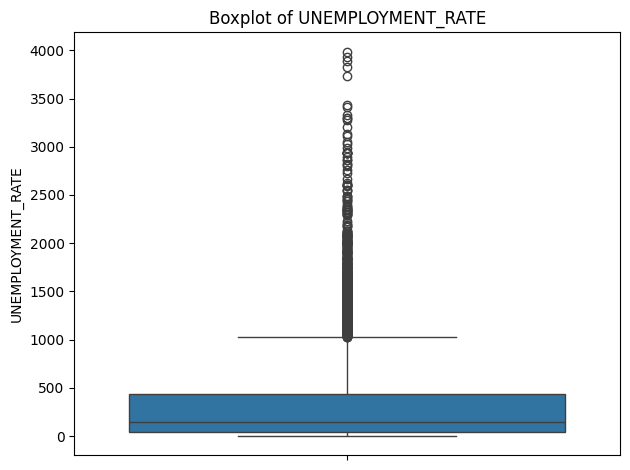

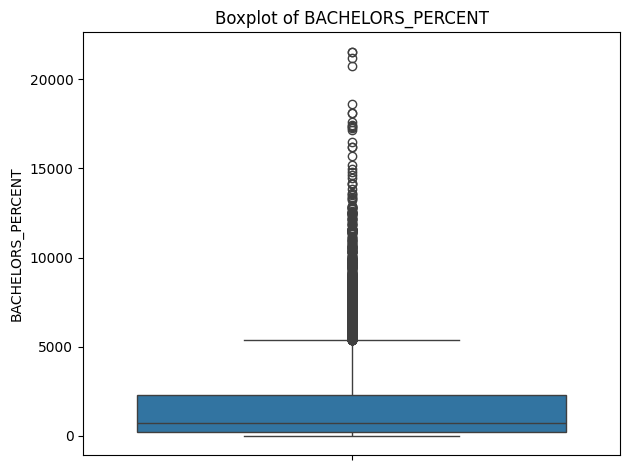

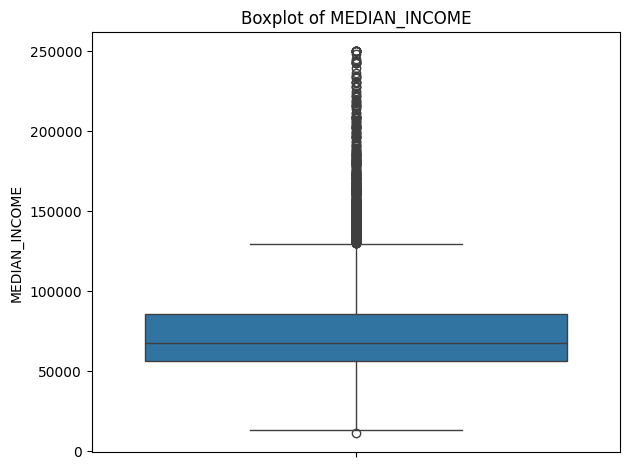

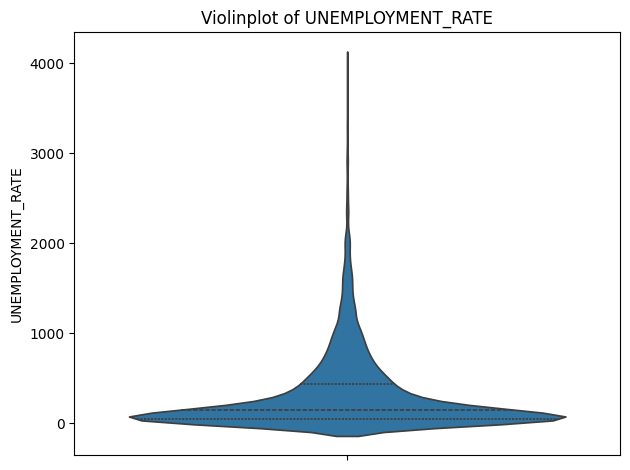

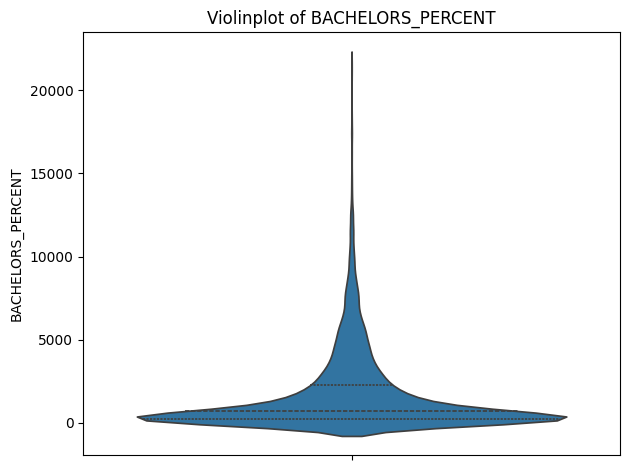

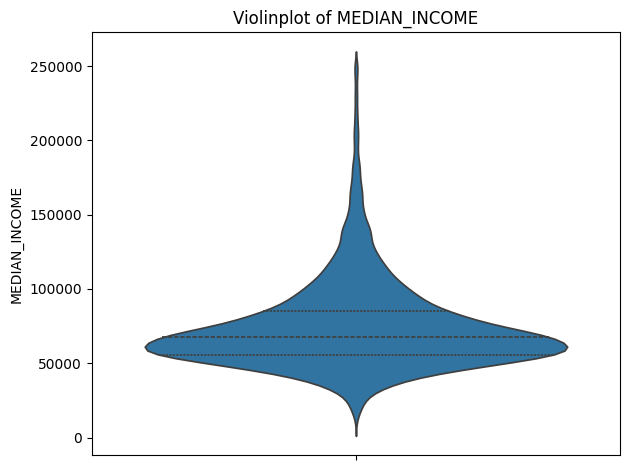

In [50]:

cols = [
    "UNEMPLOYMENT_RATE",
    "BACHELORS_PERCENT",
    "MEDIAN_INCOME"
]

# Boxplots
for col in cols:
    plt.figure()
    sns.boxplot(y=analysis_df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Violinplots
for col in cols:
    plt.figure()
    sns.violinplot(y=analysis_df[col], inner="quartile")
    plt.title(f"Violinplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Hypothesis Tests

**Hypothesis Test 1: Median Income and Library Visits**    
-H₀: Median household income and visits per capita are uncorrelated.  
-H₁: They are positively correlated.

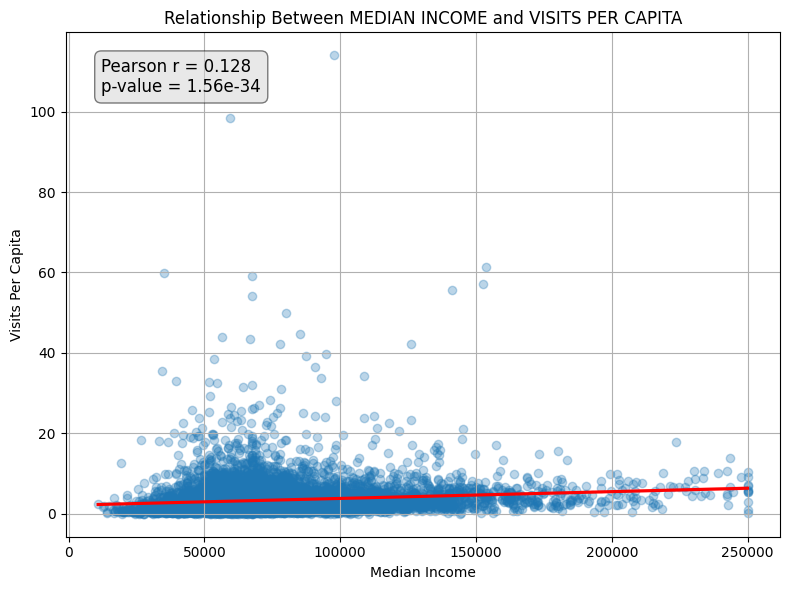

In [51]:
from scipy.stats import pearsonr

# Choose the variables
x_var = "MEDIAN_INCOME"
y_var = "VISITS_PER_CAPITA"

# Calculate Pearson correlation
r, p = pearsonr(analysis_df[x_var], analysis_df[y_var])

# Create the plot
plt.figure(figsize=(8, 6))
sns.regplot(
    data=analysis_df,
    x=x_var,
    y=y_var,
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

# Annotate correlation and p-value
plt.text(
    0.05, 0.95,
    f"Pearson r = {r:.3f}\np-value = {p:.2e}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.5)
)

plt.title(f"Relationship Between {x_var.replace('_', ' ')} and {y_var.replace('_', ' ')}")
plt.xlabel(x_var.replace("_", " ").title())
plt.ylabel(y_var.replace("_", " ").title())
plt.grid(True)
plt.tight_layout()
plt.show()

Since p-value ≪ 0.05, we reject the null hypothesis: There is statistical evidence of a non-zero association, but since r= 0.076, this result is not practically meaningful, i.e. income only very slightly predicts library visits per capita.


**Hypothesis Test 2: One-Way ANOVA**  
*Question: Do low / medium / high income ZIPs differ in mean visits per capita?*      
-H₀: All three group means of VISITS_PER_CAPITA are equal  
-H₁: At least one group mean differs

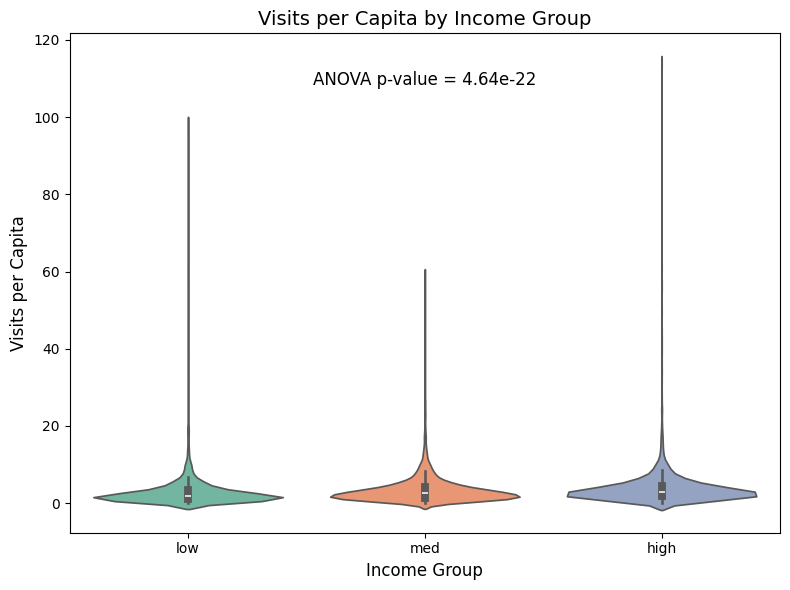

In [52]:
from scipy.stats import f_oneway

# Bin income into tertiles
df = analysis_df.copy()
df["INCOME_GROUP"] = pd.qcut(df["MEDIAN_INCOME"], 3, labels=["low","med","high"])
groups = [g.dropna() for _,g in df.groupby("INCOME_GROUP", observed=True)["VISITS_PER_CAPITA"]]
stat, p = f_oneway(*groups)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x="INCOME_GROUP",
    y="VISITS_PER_CAPITA",
    inner="box",
    palette="Set2",
    hue="INCOME_GROUP",
    legend=False
)

# Annotate p-value on plot
plt.text(
    1.0, df["VISITS_PER_CAPITA"].max() * 0.95,  
    f"ANOVA p-value = {p:.2e}",
    ha="center", fontsize=12, color="black"
)

plt.title("Visits per Capita by Income Group", fontsize=14)
plt.xlabel("Income Group", fontsize=12)
plt.ylabel("Visits per Capita", fontsize=12)
plt.tight_layout()
plt.show()

Since p-value < 0.05, we reject the null hypothesis. There is a statistically significant difference in VISITS_PER_CAPITA across income groups (low/med/high).

**Hypothesis Test 3: Chi-Square Test of Independence**  
*Question: Is there an association between ZIP code income level (Low / Medium / High) and library program offerings?*      
-H₀: Income group and program offering level are independent.  
-H₁: Income group and program offering level are associated.

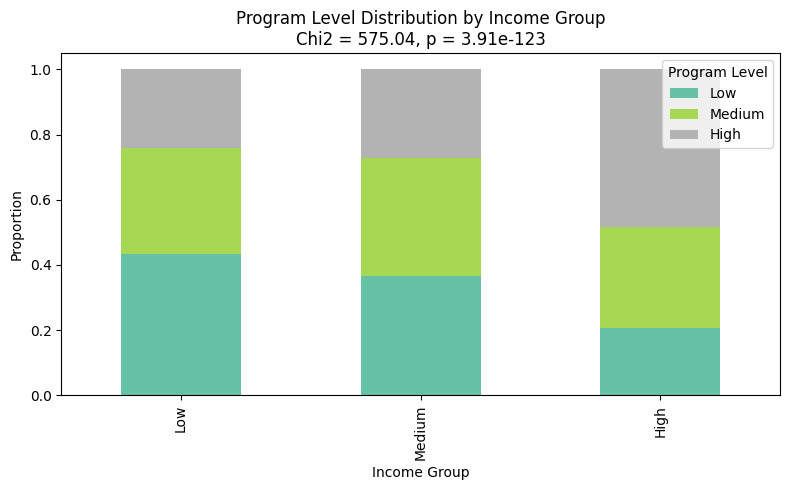

In [53]:
from scipy.stats import chi2_contingency

# 1. Filter out rows where TOTPRO was imputed
filtered_df = analysis_df[analysis_df["TOTPRO_IMPUTED"] == False].copy()

# 2. Define income group buckets (if not already defined)
filtered_df["INCOME_GROUP"] = pd.qcut(filtered_df["MEDIAN_INCOME"], q=3, labels=["Low", "Medium", "High"])

# 3. Create PROGRAM_LEVEL based on tertiles of TOTPRO
filtered_df["PROGRAM_LEVEL"] = pd.qcut(filtered_df["TOTPRO"], q=3, labels=["Low", "Medium", "High"])

# 4. Create contingency table
contingency = pd.crosstab(filtered_df["INCOME_GROUP"], filtered_df["PROGRAM_LEVEL"])

# 5. Run Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency)

contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

contingency_norm.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))

plt.title(f"Program Level Distribution by Income Group\nChi2 = {chi2:.2f}, p = {p:.2e}")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.legend(title="Program Level")
plt.tight_layout()
plt.show()

Since p_value ≪ 0.05, and even ≪ 0.001, we reject the null hypothesis. Library program levels tend to differ substantially depending on whether a ZIP code is low-, medium-, or high-income.

**Hypothesis Test 4: Two-Sample T-Test**  
*Question: Do libraries in high-income ZIP codes have significantly more library staff (TOTSTAFF) than those in low-income ZIP codes?*        
-H₀: There is no significant difference in the mean number of library staff between high-income and low-income ZIP codes.  
-H₁: There is a significant difference in the mean number of library staff between high-income and low-income ZIP codes.

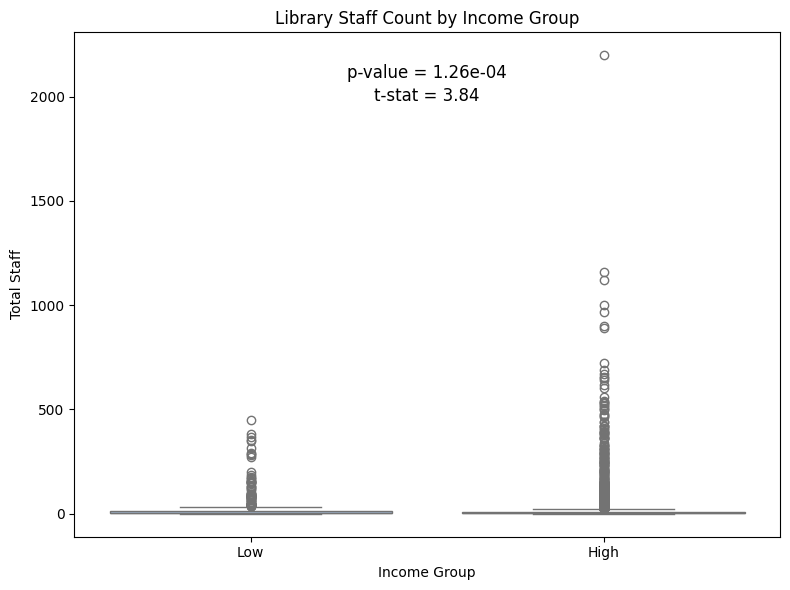

In [54]:
from scipy.stats import ttest_ind

temp_df = analysis_df.copy()

temp_df['Income_Group'] = pd.cut(temp_df['MEDIAN_INCOME'], bins=[0, 40000, np.inf], labels=['Low', 'High'])

temp_df_clean = temp_df.dropna(subset=['TOTSTAFF', 'MEDIAN_INCOME'])


low_income = temp_df_clean[temp_df_clean['Income_Group'] == 'Low']['TOTSTAFF']
high_income = temp_df_clean[temp_df_clean['Income_Group'] == 'High']['TOTSTAFF']

t_stat, p_value = ttest_ind(low_income, high_income)


plt.figure(figsize=(8, 6))
sns.boxplot(data=temp_df_clean[temp_df_clean["Income_Group"].isin(["Low", "High"])],
            x="Income_Group", y='TOTSTAFF', palette="pastel", hue="Income_Group", legend=False)

plt.title("Library Staff Count by Income Group")
plt.xlabel("Income Group")
plt.ylabel("Total Staff")

# Annotate p-value on the plot
plt.text(0.5, temp_df_clean["TOTSTAFF"].max() * 0.95,
         f'p-value = {p_value:.2e}',
         ha='center', fontsize=12, color='black')

plt.text(0.5, temp_df_clean['TOTSTAFF'].max() * 0.90,
        f't-stat = {t_stat:.2f}', ha='center',
        fontsize=12, color='black')

plt.tight_layout()
plt.show()

Since p_value ≪ 0.05, we reject the null hypothesis. The difference in the mean number of library staff between two income groups is significant, although looking at the box plot comparison, this result is not practically meaningful.

# Machine Learning

1. Setup and Tidying Features Based on VIF

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Define target and initial features (omit CHECKOUTS_PER_CAPITA & its flag)
target = "CHECKOUTS_PER_CAPITA"

features = [
    'UNEMPLOYMENT_RATE','MEDIAN_INCOME','BACHELORS_PERCENT',
    'REGBOR','GPTERMS','TOTSTAFF','HRS_OPEN','TOTPRO',
    'TOTINCM','TOTOPEXP','POPU_UND',
    # Imputation Flags (excluding CHECKOUTS_PER_CAPITA_IMPUTED)
    'VISITS_PER_CAPITA_IMPUTED','HRS_OPEN_IMPUTED','GPTERMS_IMPUTED',
    'ATTENDANCE_PER_CAPITA_IMPUTED','REGBOR_IMPUTED',
    'TOTPRO_IMPUTED','TOTSTAFF_IMPUTED','TOTINCM_IMPUTED',
    'TOTOPEXP_IMPUTED',
    # Derived Features Except The Target
    'VISITS_PER_CAPITA','ATTENDANCE_PER_CAPITA'
]


# 2) Build the arrays
X_raw = analysis_df[features].values
y = analysis_df[target].values


# 3) Identify numeric vs flag columns
flag_mask = np.array([c.endswith("_IMPUTED") for c in features])
num_mask  = ~flag_mask


# 4) Compute VIF on all numeric features (scaled once)
scaler_full = StandardScaler()
X_num_full = scaler_full.fit_transform(X_raw[:, num_mask])

vif_df = pd.DataFrame({
    "feature": np.array(features)[num_mask],
    "VIF": [variance_inflation_factor(X_num_full, i) for i in range(X_num_full.shape[1])]
}).sort_values("VIF", ascending=False)

print("=== VIF before dropping features ===")
display(vif_df)

# 5) Drop any numeric feature with VIF > 5 (and its _IMPUTED flag)
VIF_THRESHOLD = 6.0

high_vif = vif_df[vif_df["VIF"] > VIF_THRESHOLD]["feature"].tolist()
print("Dropping: ", high_vif)

for feat in high_vif:
    features.remove(feat)
    flag = f"{feat}_IMPUTED"
    if flag in features:
        features.remove(flag)

# 6) Rebuild X_raw, masks
X_raw = analysis_df[features].values
flag_mask = np.array([c.endswith("_IMPUTED") for c in features])
num_mask = ~flag_mask

# 7) Prepare 5-Fold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Final feature set:")
print(features)


=== VIF before dropping features ===


,feature,VIF
9,TOTOPEXP,112.845552
8,TOTINCM,108.191393
5,TOTSTAFF,21.228151
10,POPU_UND,9.054362
6,HRS_OPEN,6.054702
3,REGBOR,5.438960
4,GPTERMS,4.501981
7,TOTPRO,3.376735
2,BACHELORS_PERCENT,2.901187
0,UNEMPLOYMENT_RATE,2.374683


Dropping:  ['TOTOPEXP', 'TOTINCM', 'TOTSTAFF', 'POPU_UND', 'HRS_OPEN']
Final feature set:
['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'REGBOR', 'GPTERMS', 'TOTPRO', 'VISITS_PER_CAPITA_IMPUTED', 'GPTERMS_IMPUTED', 'ATTENDANCE_PER_CAPITA_IMPUTED', 'REGBOR_IMPUTED', 'TOTPRO_IMPUTED', 'VISITS_PER_CAPITA', 'ATTENDANCE_PER_CAPITA']


2. 5-Fold Cross-Validation for Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

lr_rmses, lr_r2s = [], []
lr = LinearRegression()

for fold, (train_idx, test_idx) in enumerate(kf.split(X_raw), 1):
    # Split
    X_tr_raw, X_te_raw = X_raw[train_idx], X_raw[test_idx]
    y_tr, y_te         = y[train_idx], y[test_idx]

    # Scale numeric features
    scaler = StandardScaler()
    X_tr_num = scaler.fit_transform(X_tr_raw[:, num_mask])
    X_te_num = scaler.transform(   X_te_raw[:, num_mask])

    # Reassemble features
    X_tr = np.hstack([X_tr_num, X_tr_raw[:, flag_mask]])
    X_te = np.hstack([X_te_num, X_te_raw[:, flag_mask]])

    # Train & evaluate
    lr.fit(X_tr, y_tr)
    y_pred = lr.predict(X_te)
    
    lr_rmses.append(root_mean_squared_error(y_te, y_pred))
    lr_r2s.append(r2_score(y_te, y_pred))
    print(f"Fold {fold} | Linear Regression -> RMSE {lr_rmses[-1]:.3f}, R² {lr_r2s[-1]:.3f}")


print(f"\nLinear Regression Cross-Validation RMSE: {np.mean(lr_rmses):.3f} ± {np.std(lr_rmses):.3f}")
print(f"Linear Regression Cross-Validation R²: {np.mean(lr_r2s):.3f} ± {np.std(lr_r2s):.3f}")

Fold 1 | Linear Regression -> RMSE 5.070, R² 0.299
Fold 2 | Linear Regression -> RMSE 7.080, R² 0.193
Fold 3 | Linear Regression -> RMSE 5.648, R² 0.360
Fold 4 | Linear Regression -> RMSE 4.639, R² 0.449
Fold 5 | Linear Regression -> RMSE 4.142, R² 0.405

Linear Regression Cross-Validation RMSE: 5.315 ± 1.012
Linear Regression Cross-Validation R²: 0.341 ± 0.089


3. 5-Fold Cross-Validation for k-Nearest Neighbors

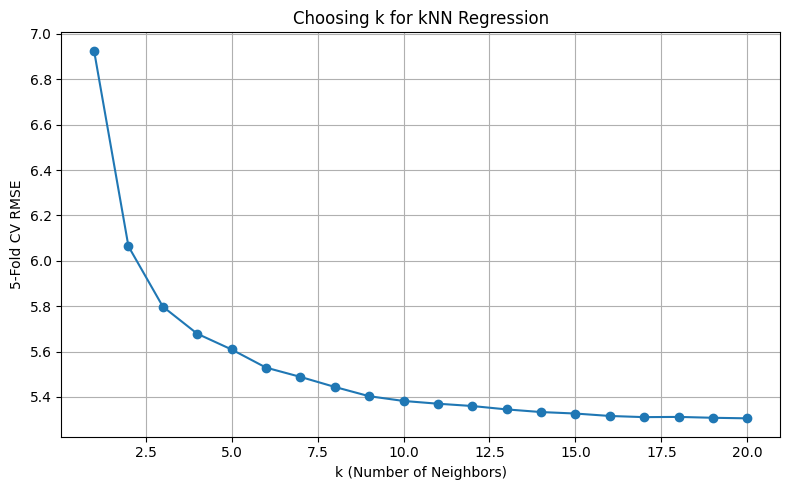

Best k: 20 with Cross-Validation RMSE = 5.306


In [57]:
from sklearn.neighbors import KNeighborsRegressor

k_values = list(range(1, 21))
cv_rmse_scores = []

for k in k_values:
    fold_rmses = []
    for train_idx, test_idx in kf.split(X_raw):
        # Split data
        X_tr_raw, X_te_raw = X_raw[train_idx], X_raw[test_idx]
        y_tr, y_te         = y[train_idx], y[test_idx]
        
        # Scale only numeric features
        scaler = StandardScaler()
        X_tr_num = scaler.fit_transform(X_tr_raw[:, num_mask])
        X_te_num = scaler.transform(   X_te_raw[:, num_mask])
        
        # Reassemble numeric + flag columns
        X_tr = np.hstack([X_tr_num, X_tr_raw[:, flag_mask]])
        X_te = np.hstack([X_te_num, X_te_raw[:, flag_mask]])
        
        # Fit kNN and compute RMSE
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        fold_rmses.append(root_mean_squared_error(y_te, y_pred))
    
    # Average RMSE for this k
    cv_rmse_scores.append(np.mean(fold_rmses))

# Plot k vs CV RMSE
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_rmse_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("5-Fold CV RMSE")
plt.title("Choosing k for kNN Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

# Select best k
best_k = k_values[np.argmin(cv_rmse_scores)]
print(f"Best k: {best_k} with Cross-Validation RMSE = {min(cv_rmse_scores):.3f}")

4. 5-Fold Cross-Validation for Decision Tree

max_depth=1 -> Cross-Validation RMSE: 5.897
max_depth=2 -> Cross-Validation RMSE: 5.537
max_depth=3 -> Cross-Validation RMSE: 5.511
max_depth=4 -> Cross-Validation RMSE: 5.626
max_depth=5 -> Cross-Validation RMSE: 5.866
max_depth=6 -> Cross-Validation RMSE: 5.897
max_depth=7 -> Cross-Validation RMSE: 6.004
max_depth=8 -> Cross-Validation RMSE: 6.194
max_depth=9 -> Cross-Validation RMSE: 6.877
max_depth=10 -> Cross-Validation RMSE: 6.332
max_depth=11 -> Cross-Validation RMSE: 6.475
max_depth=12 -> Cross-Validation RMSE: 6.958
max_depth=13 -> Cross-Validation RMSE: 6.610
max_depth=14 -> Cross-Validation RMSE: 6.793
max_depth=15 -> Cross-Validation RMSE: 7.500
max_depth=16 -> Cross-Validation RMSE: 7.021
max_depth=17 -> Cross-Validation RMSE: 6.943
max_depth=18 -> Cross-Validation RMSE: 6.882
max_depth=19 -> Cross-Validation RMSE: 7.311
max_depth=20 -> Cross-Validation RMSE: 6.953


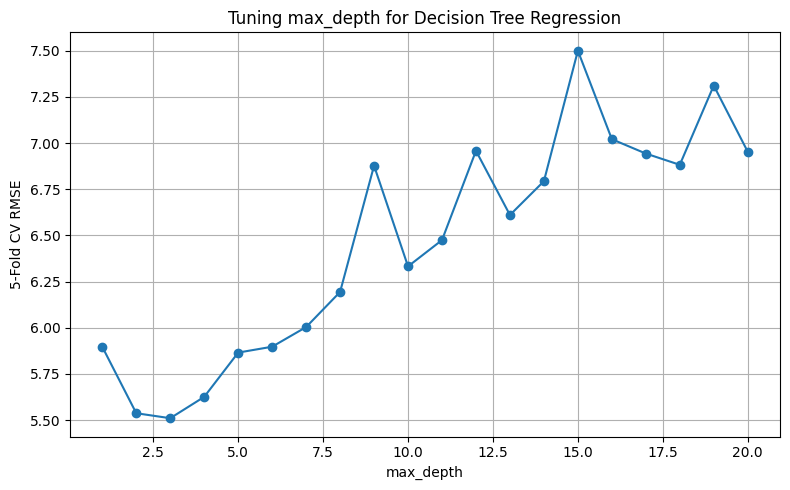


Best max_depth: 3 with Cross-Validation RMSE = 5.511


In [58]:
from sklearn.tree import DecisionTreeRegressor

# Define range of max_depth values to try
depths = list(range(1, 21))
dt_cv_rmse = []

# Manual 5-Fold CV loop over depths
for d in depths:
    fold_rmses = []
    for train_idx, test_idx in kf.split(X_raw):
        X_tr, X_te = X_raw[train_idx], X_raw[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        # No scaling needed for tree
        dt = DecisionTreeRegressor(max_depth=d, random_state=42)
        dt.fit(X_tr, y_tr)
        y_pred = dt.predict(X_te)
        fold_rmses.append(root_mean_squared_error(y_te, y_pred))
    
    mean_rmse = np.mean(fold_rmses)
    dt_cv_rmse.append(mean_rmse)
    print(f"max_depth={d} -> Cross-Validation RMSE: {mean_rmse:.3f}")

# Plot max_depth vs CV RMSE
plt.figure(figsize=(8, 5))
plt.plot(depths, dt_cv_rmse, marker='o')
plt.xlabel("max_depth")
plt.ylabel("5-Fold CV RMSE")
plt.title("Tuning max_depth for Decision Tree Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Select best max_depth
best_depth = depths[np.argmin(dt_cv_rmse)]
print(f"\nBest max_depth: {best_depth} with Cross-Validation RMSE = {min(dt_cv_rmse):.3f}")

5. 5-Fold Cross-Validation for Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter grids
depths = [3, 5, 10, 15]
estimators = [10, 50, 100]

# Dictionary to store mean CV RMSE for each (depth, n_est)
rf_results = {}

for max_depth in depths:
    for n_estimators in estimators:
        fold_rmses = []
        
        # 5-Fold manual CV
        for train_idx, test_idx in kf.split(X_raw):
            X_tr, X_te = X_raw[train_idx], X_raw[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]
            
            # No scaling needed for trees
            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42
            )
            rf.fit(X_tr, y_tr)
            y_pred = rf.predict(X_te)
            fold_rmses.append(root_mean_squared_error(y_te, y_pred))
        
        # Average RMSE across folds
        mean_rmse = np.mean(fold_rmses)
        rf_results[(max_depth, n_estimators)] = mean_rmse
        print(f"max_depth={max_depth}, n_estimators={n_estimators} -> Cross-Validation RMSE: {mean_rmse:.3f}")

# Select best hyperparameters
best_params = min(rf_results, key=rf_results.get)
best_rmse   = rf_results[best_params]
print(f"\nBest max_depth: {best_params[0]}, Best n_estimators: {best_params[1]}")
print(f"Best Cross-Validation RMSE: {best_rmse:.3f}")

max_depth=3, n_estimators=10 -> Cross-Validation RMSE: 5.367
max_depth=3, n_estimators=50 -> Cross-Validation RMSE: 5.337
max_depth=3, n_estimators=100 -> Cross-Validation RMSE: 5.339
max_depth=5, n_estimators=10 -> Cross-Validation RMSE: 5.384
max_depth=5, n_estimators=50 -> Cross-Validation RMSE: 5.304
max_depth=5, n_estimators=100 -> Cross-Validation RMSE: 5.305
max_depth=10, n_estimators=10 -> Cross-Validation RMSE: 5.461
max_depth=10, n_estimators=50 -> Cross-Validation RMSE: 5.359
max_depth=10, n_estimators=100 -> Cross-Validation RMSE: 5.326
max_depth=15, n_estimators=10 -> Cross-Validation RMSE: 5.600
max_depth=15, n_estimators=50 -> Cross-Validation RMSE: 5.372
max_depth=15, n_estimators=100 -> Cross-Validation RMSE: 5.345

Best max_depth: 5, Best n_estimators: 50
Best Cross-Validation RMSE: 5.304


6. 5-Fold Cross-Validation for XGBoost

In [60]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 1) Base regressor
xgb_reg = xgb.XGBRegressor(random_state=42, verbosity=0)

# 2) Hyperparameter grid
param_grid = {
    "n_estimators":  [50, 100],
    "max_depth":     [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample":     [0.8, 1.0]
}

# 3) Custom scorer using root_mean_squared_error
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# 4) GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=kf,
    scoring=rmse_scorer,
    n_jobs=-1
)

# 5) Fit on full data
grid_search.fit(X_raw, y)

# 6) Report best parameters and RMSE
best_params = grid_search.best_params_
best_rmse   = -grid_search.best_score_  # make positive again

print("Best Parameters:", best_params)
print(f"Best 5-Fold Cross-Validation RMSE: {best_rmse:.3f}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best 5-Fold Cross-Validation RMSE: 5.182


# Results

Best performing model: XGBoost with hyperparameters,
- n_estimators = 100
- max_depth = 3
- learning_rate = 0.05
- subsample = 0.8
- Cross-Validation RMSE = 5.182

In [64]:
# 1a) Initialize the model with the chosen hyperparameters
best_xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42,
    verbosity=0
)

# 1b) Fit on the entire dataset
best_xgb.fit(X_raw, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

,feature,importance
11,VISITS_PER_CAPITA,0.336811
5,TOTPRO,0.145967
12,ATTENDANCE_PER_CAPITA,0.115551
1,MEDIAN_INCOME,0.101275
2,BACHELORS_PERCENT,0.092063
4,GPTERMS,0.082518
3,REGBOR,0.067982
0,UNEMPLOYMENT_RATE,0.057832
6,VISITS_PER_CAPITA_IMPUTED,0.000000
8,ATTENDANCE_PER_CAPITA_IMPUTED,0.000000


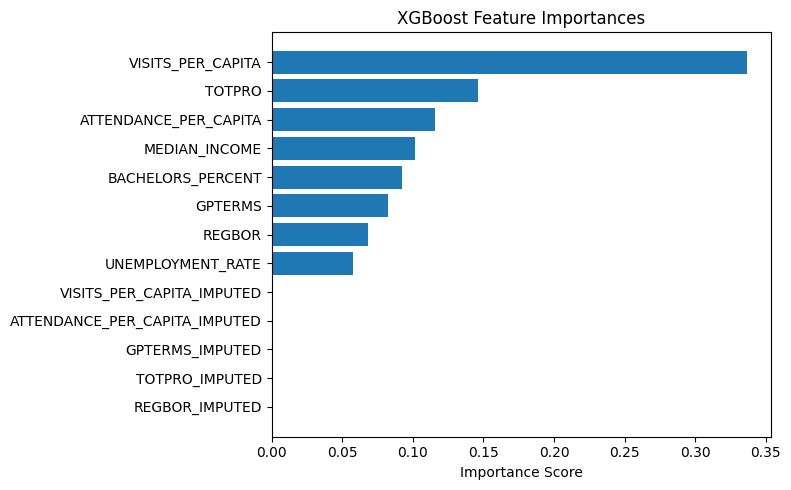

In [65]:
# 2a) Get raw importances
importances = best_xgb.feature_importances_

# 2b) Build a DataFrame for easy sorting/plotting
fi_df = pd.DataFrame({
    "feature": features, 
    "importance": importances
}).sort_values("importance", ascending=False)

# 2c) Display as a table
display(fi_df)

# 2d) Display as a horizontal bar plot
plt.figure(figsize=(8, 5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()